In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import torch

import defmod as dm
import multimodule_usefulfunctions as mm 
import hamiltonian_multishape as ham
import kernels as ker

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
## define reference and template shape
r = [3,2]
origin1 = [[-3,0], [6,6]]
origin2 = [[0,3], [6,4]]
nb_points = [10,7]

source = mm.multipleCircles(origin1, r ,nb_points)
target = mm.multipleCircles(origin2, r ,nb_points)

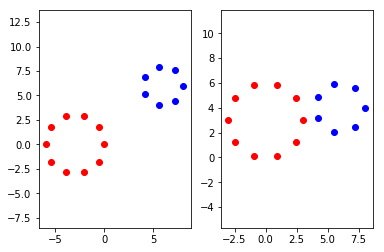

In [3]:
plt.subplot(1,2,1)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.subplot(1,2,2)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
## Define Deformation Modules
dim = 2
nb_shapes = 2

# Module 1: Translation of first circle
sigma1 = 10
trans1 = dm.deformationmodules.Translations(dim, 1, sigma1)

# Module 2: Translation of second circle
sigma2 = 10
trans2 = dm.deformationmodules.Translations(dim,1, sigma2)

# Module 3: Background Module
sigma3 = 1.5
nb_pts = nb_points[0] + nb_points[1]
background = dm.deformationmodules.Translations(dim, nb_pts, sigma3)


module_list = [trans1, trans2, background]
dim_controls = dim*(1+1+nb_pts)

In [5]:
sigma = [sigma1, sigma2, sigma3]
z = [mm.computeCenter(source[0]), mm.computeCenter(source[1])]

#initialize gd and momentum
mom_tmp0 = np.zeros([nb_points[0], dim])
mom_tmp0[:,1] = 10.
mom_tmp1 = np.zeros([nb_points[1], dim])
mom_tmp1[:,1] = -10.
gd_list = [source[0], source[1], torch.cat([source[0], source[1]],0)]
mom_list = [torch.tensor(mom_tmp0.copy(), requires_grad=True, dtype=torch.float32), torch.tensor(mom_tmp1.copy(),requires_grad=True, dtype=torch.float32), torch.tensor(np.zeros(gd_list[2].shape),requires_grad=True, dtype=torch.float32)]

# compute geodesic control and lagrange multiplier
l_list = mm.lambda_qp(gd_list, mom_list, sigma, z, dim)
controls_list = mm.h_qp(gd_list, mom_list, l_list, sigma, z, dim)

# Constraints (identity)
Constr1 = torch.cat([torch.eye(nb_points[0]), torch.zeros([nb_points[0], nb_points[1]]), -torch.eye(nb_points[0]), torch.zeros([nb_points[0], nb_points[1]])], 1)
Constr2 = torch.cat([torch.zeros([nb_points[1], nb_points[0]]), torch.eye(nb_points[1]), torch.zeros([nb_points[1], nb_points[0]]), -torch.eye(nb_points[1]),], 1)
Constr = [Constr1, Constr2]

# reduced Hamiltonian 
dim_control = [controls_list[0].shape, controls_list[1].shape, controls_list[2].shape]
H = ham.Hamiltonian_Multishape(module_list, dim_control)

In [6]:
# check boundary constraints
grad = torch.autograd.grad(H(gd_list, mom_list, controls_list, z, l_list, Constr),[*gd_list, *mom_list], create_graph=True)

speed_gd1 = grad[3]
speed_gd31 = grad[5][0:nb_points[0]]

speed_gd3 = grad[5]
speed_gd2 = grad[4]
speed_gd32 = grad[5][nb_points[0]:]

In [7]:
torch.autograd.grad(H(gd_list, mom_list, controls_list, z, l_list, Constr),controls_list)

(tensor([[ 0.0000e+00, -4.7684e-06]]),
 tensor([[ 0.0000e+00, -1.9073e-06]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]))

In [8]:
torch.autograd.grad(H(gd_list, mom_list, controls_list, z, l_list, Constr),l_list)

(tensor([[0.0000e+00, 4.3580e-06],
         [0.0000e+00, 7.2190e-06],
         [0.0000e+00, 2.4506e-06],
         [0.0000e+00, 2.4506e-06],
         [0.0000e+00, 4.3580e-06],
         [0.0000e+00, 2.4506e-06],
         [0.0000e+00, 5.4327e-07],
         [0.0000e+00, 1.4969e-06],
         [0.0000e+00, 6.2653e-06],
         [0.0000e+00, 6.2653e-06]]), tensor([[ 0.0000e+00,  4.6936e-06],
         [ 0.0000e+00,  1.8326e-06],
         [ 0.0000e+00,  2.7862e-06],
         [ 0.0000e+00,  4.6936e-06],
         [ 0.0000e+00, -1.0285e-06],
         [ 0.0000e+00,  3.7399e-06],
         [ 0.0000e+00,  3.7399e-06]]))

In [38]:
H.apply_constraints(gd_list, [z[0], z[1], gd_list[2]], l_list, controls_list, Constr)

tensor(0.0001, grad_fn=<AddBackward0>)

In [39]:
speed = torch.cat([speed_gd1, speed_gd2, speed_gd3],0)

In [40]:

from kernels import scal

scal(l_list[0].contiguous(), torch.mm(Constr[0],speed))

tensor(-8.1327e-05, grad_fn=<DotBackward>)

In [41]:
speed_app1 = trans1(mm.computeCenter(gd_list[0]), controls_list[0], gd_list[0])
speed_app2 = trans2(mm.computeCenter(gd_list[1]), controls_list[1], gd_list[1])
speed_app3 = background(gd_list[2], controls_list[2], gd_list[2])

In [42]:
speed_app = torch.cat([speed_app1, speed_app2, speed_app3],0)

In [44]:
speed_app - speed

tensor([[ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  1.9073e-06],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  9.5367e-07],
        [ 0.0000e+00,  3.8147e-06],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00,  9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -2.8610e-06],
        [ 0.0000e+00, -1.9073e-06],
        [ 0.0000e+00,  2.8610e-06],
        [ 0.0000e+00,  2.8610e-06],
        [ 0.0000e+00,  1.907

In [26]:
len(grad)

6

In [27]:
speed_gd1 - speed_gd31

tensor([[ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07],
        [ 0.0000e+00, -9.5367e-07]], grad_fn=<SubBackward0>)

In [49]:
gd_t, mom_t, controls_t = mm.shootMultishape(gd_list, mom_list, H, Constr, sigma, dim, n=10)


In [52]:
gd_t[-1][0]

tensor([[ 2.2276e-03,  1.2297e+01],
        [-5.7072e-01,  1.4060e+01],
        [-2.0707e+00,  1.5150e+01],
        [-3.9248e+00,  1.5150e+01],
        [-5.4248e+00,  1.4060e+01],
        [-5.9978e+00,  1.2297e+01],
        [-5.4248e+00,  1.0534e+01],
        [-3.9248e+00,  9.4439e+00],
        [-2.0707e+00,  9.4439e+00],
        [-5.7072e-01,  1.0534e+01]], grad_fn=<AddBackward0>)

In [53]:
gd_t[-1][2]

tensor([[ 2.2276e-03,  1.2297e+01],
        [-5.7072e-01,  1.4060e+01],
        [-2.0707e+00,  1.5150e+01],
        [-3.9248e+00,  1.5150e+01],
        [-5.4248e+00,  1.4060e+01],
        [-5.9978e+00,  1.2297e+01],
        [-5.4248e+00,  1.0534e+01],
        [-3.9248e+00,  9.4439e+00],
        [-2.0707e+00,  9.4439e+00],
        [-5.7072e-01,  1.0534e+01],
        [ 7.9968e+00, -6.5181e+00],
        [ 7.2437e+00, -4.9544e+00],
        [ 5.5517e+00, -4.5682e+00],
        [ 4.1948e+00, -5.6503e+00],
        [ 4.1948e+00, -7.3858e+00],
        [ 5.5517e+00, -8.4679e+00],
        [ 7.2437e+00, -8.0817e+00]], grad_fn=<AddBackward0>)

In [31]:
gd_t, mom_t, controls_t = mm.shootMultishape(gd_list, mom_list, H, Constr, sigma, dim, n=10)

gd_final = gd_t[len(gd_t)-1]
mom_final = mom_t[len(mom_t)-1]


z_final = [mm.computeCenter(source[0]), mm.computeCenter(source[1])]
l_final = mm.lambda_qp(gd_final, mom_final, sigma, z_final, dim)
control_final = mm.h_qp(gd_final, mom_final, l_final, sigma, z, dim)

nb_modules = 2
N = len(controls_t)
center_t = torch.zeros( N, nb_modules, dim)
for t in range(N):
    for m in range(2):
        center_t[t, m] = mm.computeCenter(gd_t[t][m])

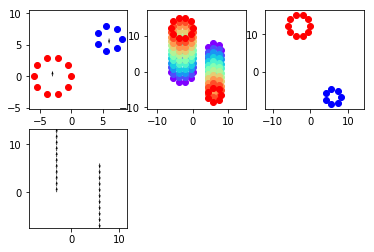

In [32]:
import matplotlib.cm as cm

plt.subplot(2,3,1)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
mm.plotControl(controls_list, z)
plt.axis('equal')

plt.subplot(2,3,2)
colors = cm.rainbow(np.linspace(0, 1, len(gd_t)))
for i,c in zip(range(len(gd_t)), colors):
    plt.scatter(gd_t[i][0][:,0].detach().numpy(), gd_t[i][0][:, 1].detach().numpy(), color=c)
    plt.scatter(gd_t[i][1][:,0].detach().numpy(), gd_t[i][1][:, 1].detach().numpy(), color=c)
plt.axis('equal')

plt.subplot(2,3,3)
plt.scatter(gd_final[0][:, 0].detach().numpy(), gd_final[0][:, 1].detach().numpy(), c='red')
plt.scatter(gd_final[1][:, 0].detach().numpy(), gd_final[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.subplot(2,3,4)
for i in range(len(controls_t)):
    mm.plotControl(controls_t[i], [center_t[i][0],center_t[i][1]])
plt.axis('equal')

plt.show()

In [33]:
controls1_t = []
controls2_t = []
controls3_t = []
gd3_t = []

for t in range(len(controls_t)):
    controls1_t.append(controls_t[t][0])
    controls2_t.append(controls_t[t][1])
    controls3_t.append(controls_t[t][2])
    gd3_t.append(gd_t[t][2])

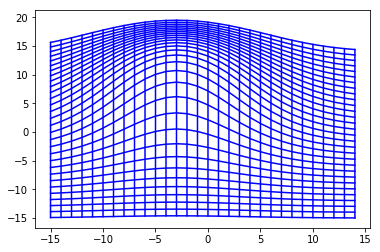

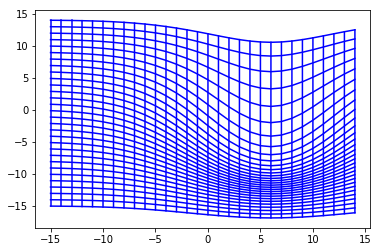

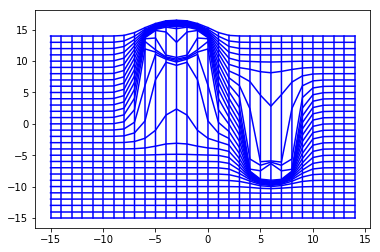

In [34]:
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.FloatTensor)/nx - 0.5)
y = sy*(y.type(torch.FloatTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.FloatTensor)


phi1 = mm.largeDeformation(trans1, center_t[:,0,:], controls1_t, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi1, nx, ny)

phi2 = mm.largeDeformation(trans2, center_t[:,1,:], controls2_t, gridpoints)
x2, y2 = dm.usefulfunctions.vec2grid(phi2, nx, ny)

phi3 = mm.largeDeformation(background, gd3_t, controls3_t, gridpoints)
x3, y3 = dm.usefulfunctions.vec2grid(phi3, nx, ny)


mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue')
mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue')
mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue')
plt.show()


In [54]:
gd_list[0]

tensor([[ 0.0000e+00,  0.0000e+00],
        [-5.7295e-01,  1.7634e+00],
        [-2.0729e+00,  2.8532e+00],
        [-3.9271e+00,  2.8532e+00],
        [-5.4271e+00,  1.7634e+00],
        [-6.0000e+00,  3.6739e-16],
        [-5.4271e+00, -1.7634e+00],
        [-3.9271e+00, -2.8532e+00],
        [-2.0729e+00, -2.8532e+00],
        [-5.7295e-01, -1.7634e+00]], requires_grad=True)

In [55]:
 center_t[:,0,:]

tensor([[-3.0000,  0.0000],
        [-3.0000,  1.2297],
        [-3.0000,  2.4594],
        [-3.0000,  3.6891],
        [-2.9998,  4.9188],
        [-2.9995,  6.1485],
        [-2.9991,  7.3782],
        [-2.9988,  8.6079],
        [-2.9985,  9.8376],
        [-2.9981, 11.0673],
        [-2.9978, 12.2970]], grad_fn=<SliceBackward>)

In [56]:
len( center_t[:,0,:])

11

In [57]:
# check if points are transported the same way by translation and background

phi1q = mm.largeDeformation(trans1, center_t[:,0,:], controls1_t, gd_list[0])
phi2q = mm.largeDeformation(trans2, center_t[:,1,:], controls2_t, gd_list[1])
phi3q = mm.largeDeformation(background, gd3_t, controls3_t, torch.cat([gd_list[0], gd_list[1]],0))

torch.cat([phi1q, phi2q],0) - phi3q

tensor([[-2.2328e-07,  0.0000e+00],
        [ 5.9605e-08, -9.5367e-07],
        [-2.3842e-07,  9.5367e-07],
        [-1.4305e-06,  2.8610e-06],
        [-9.5367e-07,  0.0000e+00],
        [-1.9073e-06, -3.8147e-06],
        [-9.5367e-07, -1.9073e-06],
        [-7.1526e-07, -5.7220e-06],
        [-1.1921e-06, -5.7220e-06],
        [ 4.1723e-07, -9.5367e-07],
        [ 0.0000e+00, -1.9073e-06],
        [-9.5367e-07, -7.6294e-06],
        [ 4.7684e-07, -9.5367e-07],
        [-1.4305e-06, -4.7684e-07],
        [ 9.5367e-07,  0.0000e+00],
        [ 4.7684e-07,  0.0000e+00],
        [-4.7684e-07, -1.9073e-06]], grad_fn=<SubBackward0>)

In [36]:
label = mm.pointInCircles(x,y,z,r)

color = ['red', 'blue', 'white']
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        plt.scatter(x[i][j].numpy(), y[i][j].numpy() , c=color[int(label[i][j].numpy())-1])
#plt.axis('equal')
#plt.show()


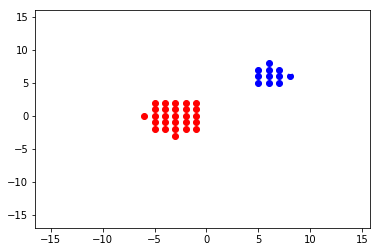

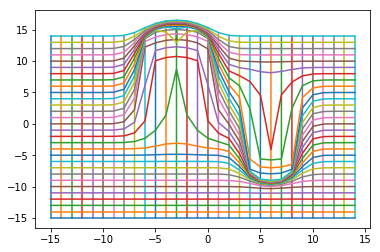

In [37]:
grid = [x,y]
phi = [[x1,y1], [x2,y2], [x3,y3]]

mm.plot_MultiGrid(phi, grid, label)
plt.show()